# Image classification for vehicle body type

### Summary

The goal is to recognize a body type for a vehicle in order to infer a CO2 emission


## Libraries

In [1]:
# Utils
import sys
import os
import shutil
import time
import pickle
import numpy as np
from PIL import Image
sys.modules['Image'] = Image 

# Deep Learning Librairies
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

# due to error : failed to initialize cudnn
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import tensorflow.keras.preprocessing.image as kpi
import tensorflow.keras.layers as kl
import tensorflow.keras.optimizers as ko
import tensorflow.keras.backend as k
import tensorflow.keras.models as km
import tensorflow.keras.applications as ka

# Data visualization
from matplotlib import pyplot as plt

from tensorflow.python.client import device_lib
MODE = "GPU" if "GPU" in [k.device_type for k in device_lib.list_local_devices()] else "CPU"
print(MODE)

GPU


In [2]:
path_data = '../data/vehicle_images' # data path
path_data_train = path_data + '/train'
path_data_val = path_data + '/val'
path_pretrained_weights_data = "data/pretrained_weights"

car_body_types = ['berline', 'break', 'cabriolet', 'combispace', 'coupe', 'minibus', 'minispace', 'monospace', 'monospace compact', 'tous-terrains']

img_width = 150
img_height = 150
IMG_SHAPE = (img_width, img_height, 3)

n_train_image = 1407
n_val_image = 439

# batch_size = 10
# epochs = n_train_image//batch_size
# steps_per_epoch = int(n_train_image/batch_size)

batch_size = 1
epochs = 5
steps_per_epoch = n_train_image // (batch_size * epochs)
validation_steps = int(n_val_image // batch_size)

In [3]:
# data generator
train_datagen = kpi.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.4,
#         class_mode='categorical',
        horizontal_flip=True,
#         vertical_flip=True
)

test_datagen = kpi.ImageDataGenerator(rescale=1./255)

generator_train = train_datagen.flow_from_directory(
    path_data_train,
    target_size=(img_width, img_height),
    batch_size=batch_size,
#         class_mode=None,
#         shuffle=False
)

generator_val = test_datagen.flow_from_directory(
    path_data_val,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False)

Found 1407 images belonging to 10 classes.
Found 439 images belonging to 10 classes.


### Fine tuning

In [9]:
def get_model():
  
    input_tensor = tf.keras.Input(shape=IMG_SHAPE)  # this assumes K.image_data_format() == 'channels_last'

    # create the base pre-trained model
    base_model = ka.ResNet50V2(input_tensor=input_tensor,weights='imagenet',include_top=False)

    for layer in base_model.layers:
        layer.trainable=False

    x = base_model.output
    x = kl.GlobalAveragePooling2D(data_format='channels_last')(x)
    x = kl.Dropout(0.5)(x)
    x = kl.Dense(len(car_body_types), activation='relu')(x)

    updatedModel = tf.keras.Model(base_model.input, x)

    return updatedModel

In [10]:
def training():

    # model building
    model_new = get_model()
    model_new.compile(optimizer='rmsprop',
                             loss='binary_crossentropy',
                             metrics=['accuracy'])


    print("\n\n##################################")
    print("modèle utilisé : ")
    print("##################################\n\n")

    # model training
    history = model_new.fit_generator(generator=generator_train,
                         epochs=epochs,
                         steps_per_epoch=steps_per_epoch,
                         validation_steps=validation_steps,
                         validation_data=generator_val)
    
    return model_new, history

In [11]:
model = None
history = None

with tf.device("/gpu:0"):
    model, history = training()



##################################
modèle utilisé : 
##################################


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 281 steps, validate for 439 steps
Epoch 1/5
281/281 [==============================] - 21s 75ms/step - loss: 1.5212 - accuracy: 0.8996 - val_loss: 1.5596 - val_accuracy: 0.8938
Epoch 2/5
281/281 [==============================] - 18s 63ms/step - loss: 1.5427 - accuracy: 0.9000 - val_loss: 1.5543 - val_accuracy: 0.8948
Epoch 3/5
281/281 [==============================] - 17s 62ms/step - loss: 1.5387 - accuracy: 0.9000 - val_loss: 1.5446 - val_accuracy: 0.8975
Epoch 4/5
281/281 [==============================] - 18s 64ms/step - loss: 1.5425 - accuracy: 0.9000 - val_loss: 1.5501 - val_accuracy: 0.8979
Epoch 5/5
281/281 [==============================] - 19s 66ms/step - loss: 1.5425 - accuracy: 0.9000 - val_loss: 1.5501 - val_accuracy: 0.8979


In [12]:
features_train = model.predict_generator(generator_train, n_train_image / batch_size, verbose=1)  
train_labels = np.array([0] * int((n_train_image/2)) + [1] * int((n_train_image/2)))
validation_labels = np.array([0] * int((n_val_image/2)) + [1] * int((n_val_image/2)))
features_validation = model.predict_generator(generator_val, n_val_image / batch_size, verbose=1)

439/439 [==============================] - 8s 19ms/step


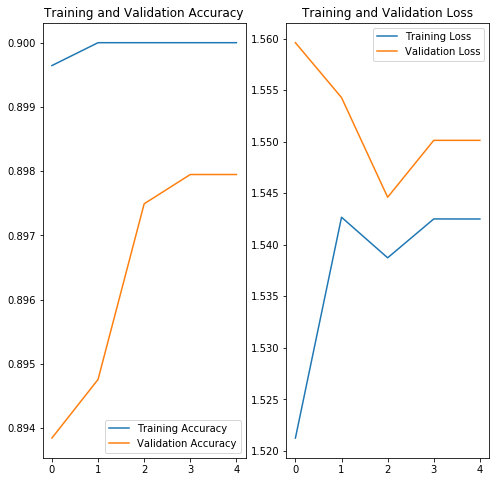

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
model.save_weights(path_pretrained_weights_data + "ResNet50V2" +'_fully_connected_model_%d_epochs_%d_batch_size.h5' %(epochs, batch_size))

In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
____________________________________________________________________________________________